## Creating mouse diploid allele scripts

### Creating deploid transcriptome 

We used scripts from `https://github.com/narayananr/diploid_txome` to generate the diploid transcriptome. The mouse data is generated using polyester. The polyester is fed with the mouse dataset with accession number `SRR207106`. 

For Salmon quantification, alignment, terminus grouping, and mmcollapse grouping the same commands found in `Plots_Related_To_Human_Simulated_4x4_Dataset.ipynb` are used. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
import readBootstraps
from collections import defaultdict

In [16]:
def group_map(gf, tnames, dup_dict = None):
    group_map = defaultdict(list)
    groups = {}
    if dup_dict is None: 
        with open(gf) as fp:
            for line in fp:
                names = line.strip().split(',')
                for n in names[1:]:
                    groups[n] = names[0]
                    group_map[names[0]].append(n)
    else:
        with open(gf) as fp:
            for line in fp:
                names = line.strip().split(',')
                for n in names[1:]:
                    if n in dup_dict:
                        groups[dup_dict[n]] = names[0]
                    groups[n] = names[0]
    for n in tnames:
        if not n in groups:
            groups[n] = n                           
    return groups,group_map


def get_joined_df_mouse_allele():
    true_df = pd.read_csv('/mnt/scratch1/hirak/ASE_Analysis/simulation/fastq/mouse_diploid/sim_counts.tsv',
           header = None, sep = '\t', names = ['transcript','count'])
    
    with open(
        '/mnt/scratch1/hirak/ASE_Analysis/simulation/mmseq_quant_mouse_feynman/sample_01.mmseq'
    ) as fp:
        numreads = int(fp.readline().strip().split(' ')[-1])
    d = pd.read_csv(
        '/mnt/scratch1/hirak/ASE_Analysis/simulation/mmseq_quant_mouse_feynman/sample_01.mmseq',
        skiprows = 1,
        sep = '\t'
    )

    d['mmseq_numreads'] = np.exp(d.log_mu_em)
    d.mmseq_numreads = d.mmseq_numreads * d.effective_length
    d.mmseq_numreads = d.mmseq_numreads / 1e9
    d.mmseq_numreads = d.mmseq_numreads * numreads
    
    mmseq_df = d.copy()
    
    salmon_df = pd.read_csv(
                '/mnt/scratch1/hirak/ASE_Analysis/simulation/quant_witohut_decoy/mouse_emase/quant.sf',
                 sep = '\t'
             )
    
    joint_df = true_df.set_index('transcript').join(salmon_df.set_index('Name')[['NumReads']], how = 'outer').join(
        mmseq_df.set_index('feature_id')['mmseq_numreads']
    ).fillna(0)
    
    
    # terminus
    gr,gmap = group_map(
        '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy_mouse/mouse_emase/clusters.txt'
        ,joint_df.index.values
    )
    
    terminus_tg = pd.DataFrame(joint_df[['count']].groupby(gr)['count'].sum())
    terminus_df = terminus_tg.join(pd.read_csv(
        '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy_mouse/mouse_emase/quant.sf',
        sep = '\t'
    ).set_index('Name')['NumReads'])
    
    # mmcollapse
    mmcollapse_df = pd.read_csv(
            '/mnt/scratch1/hirak/ASE_Analysis/simulation/mmseq_quant_mouse_feynman/sample_01.collapsed.mmseq',
            skiprows = 1,
            sep = '\t'
    )
    import re
    mmcollapse_groups = {}
    group_names = []
    grouped_transcripts_mmcollapse = []
    for t in joint_df.index.values:
        mmcollapse_groups[t] = t
    for t in mmcollapse_df.feature_id.values:
        if ('+' in t) or ('*' in t):
            cands = re.split('\+|\*', t)
            for c in cands:
                mmcollapse_groups[c] = t
                grouped_transcripts_mmcollapse += [c]
            group_names += [t]
        else:
            mmcollapse_groups[t] = t
    
    mmcollapse_df = joint_df[['count','mmseq_numreads']].groupby(mmcollapse_groups).sum()
    
    return(joint_df, terminus_df, mmcollapse_df, mmcollapse_groups)


def relDiff(c1, c2, DF, cutoff=0.01, verbose=False):
    import pandas as pd
    """
    Computes the relative difference between the values
    in columns c1 and c2 of DF.
    c1 and c2 are column names and DF is a Pandas data frame.
    Values less than cutoff will be treated as 0.

    The relative difference is defined as

    d(x_i, y_i) =
        0.0 if x_i and y_i are 0
        (x_i - y_i) / (|x_i + y_i|) otherwise

    This function returns two values.

    rd is a DataFrame where the "relDiff" column contains all
    of the computed relative differences.

    nz is a set of indexes into rd for data points where
    x_i and y_i were not *both* zero.
    """
    import numpy as np
    rd = pd.DataFrame(data = {"Name" : DF.index, "relDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] < cutoff) & (DF[c2] < cutoff)].index
    nonZero = DF.index.difference(bothZero)
    if (verbose):
        print("Zero occurs in both columns {} times".format(len(rd.loc[bothZero])))
        print("Nonzero occurs in at least 1 column {} times".format(len(rd.loc[nonZero])))
    allRD = 2.0 * ((DF[c1] - DF[c2]) / (DF[c1] + DF[c2]).abs())
    assert(len(rd.loc[nonZero]["relDiff"]) == len(allRD[nonZero]))
    rd["relDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["relDiff"][bothZero] = 0.0
    return rd, nonZero


def get_spearman_mard(j,t,m):
    print('Correlation')
    print('mmcollapse', m.corr('spearman')['count']['mmseq_numreads'])
    print('Salmon', j[['count','NumReads']].corr('spearman')['count']['NumReads'])
    print('Terminus', t.corr('spearman')['count']['NumReads'])
    
    
    print('MARD')
    print('mmcollapse', relDiff('count','mmseq_numreads',m)[0]['relDiff'].abs().mean())
    print('Salmon', relDiff('count','NumReads',j[['count','NumReads']])[0]['relDiff'].abs().mean())
    print('Terminus', relDiff('count','NumReads',t)[0]['relDiff'].abs().mean())
    

In [3]:
all_tools_df, terminus_df , mmcollapse_df, mmcollapse_group = get_joined_df_mouse_allele()

#### Table 1

In [17]:
get_spearman_mard(all_tools_df,terminus_df,mmcollapse_df)

Correlation
mmcollapse 0.814836952150704
Salmon 0.911164777766557
Terminus 0.9550813691556088
MARD
mmcollapse 0.12741021898052873
Salmon 0.12374325183997564
Terminus 0.07990832890140517


In [20]:
duplicate_transcripts = pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/index/emase_idx/duplicate_clusters.tsv',
    sep = '\t',
)

dup_tr_list =  duplicate_transcripts.values.flatten()
dup_dict = {}
i = 0
for tup in duplicate_transcripts.itertuples():
    dup_dict[tup.RetainedRef] = tup.DuplicateRef
    dup_dict[tup.DuplicateRef] = tup.RetainedRef
    i += 1

def get_joint_df(
    cluster_file,
    mercury_quant_file,
    salmon_quant_file,
):

    true_count = pd.read_csv('/mnt/scratch1/hirak/ASE_Analysis/simulation/fastq/mouse_diploid/sim_counts.tsv',
           header = None, sep = '\t', names = ['transcript','count'])
    groups = defaultdict(list)
    tr2grp_id = {}
    
    with open(cluster_file) as fp:
        for line in fp:
            names = line.strip().split(',')
            for n in names[1:]:
                if 'EN' in n:
                    groups[names[0]].append(n)
                    tr2grp_id[n] = names[0]
                    
    grouped_transcripts = [g1 for sub in [g for _,g in groups.items()] for g1 in sub]
    
    quant_df = pd.read_csv(salmon_quant_file,
                      sep = '\t')
    
    gr,gmap = group_map(cluster_file, 
                   quant_df['Name'],dup_dict)
    
    
    print(len(quant_df))
    
    quant_df['NameOrig'] = quant_df.Name.str.split('_').str[0]
    allele_group = quant_df[['Name','NameOrig']].set_index('Name').to_dict()
    
    allele_group = allele_group['NameOrig']
    print(len(allele_group))
    
    true_count = true_count.set_index('transcript').join(quant_df.set_index('Name'), how='outer').fillna(0)
    salmon_count = true_count.copy()
    
    true_count_sum = pd.DataFrame(true_count[['count','NumReads']].groupby(allele_group).sum())
    true_count['NameOrig'] = true_count.index.str.split('_').str[0]
    
    tg = pd.DataFrame(true_count[['count']].groupby(gr)['count'].sum())
    print(tg.shape)
    mercury_df = pd.read_csv(mercury_quant_file,
                            sep = '\t').set_index('Name')[['NumReads']]
    
    mercury_df = mercury_df.join(tg).fillna(0)
    
    true_count_sum.reset_index(inplace = True)
    true_count_sum.columns = ['NameOrig','count_sum','NumReads_sum']
    true_count.reset_index(inplace = True)
    true_count_joined =  pd.merge(true_count, true_count_sum, on = 'NameOrig')
    
    true_count_joined['ratio_truth'] = true_count_joined['count'] / true_count_joined['count_sum']
    true_count_joined['ratio_salmon'] = true_count_joined['NumReads'] / true_count_joined['NumReads_sum']
    
    true_count_joined.reset_index(inplace=True)
    true_count_joined['group_status'] = "false"
    true_count_joined.loc[true_count_joined['index'].isin(grouped_transcripts),'group_status'] = "true"
    
    return {
        'groups': groups,
        'revgroup': tr2grp_id,
        'group_flat':grouped_transcripts,
        'joined_df': true_count_joined,
        'mercury_count':mercury_df,
        'salmon_count': salmon_count
        
    }


In [21]:
res = get_joint_df(
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy_mouse/mouse_emase/clusters.txt',
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy_mouse/mouse_emase/quant.sf', 
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/quant_witohut_decoy/mouse_emase/quant.sf'
)

267698
267698
(248011, 1)


#### Supplementary Figure S8

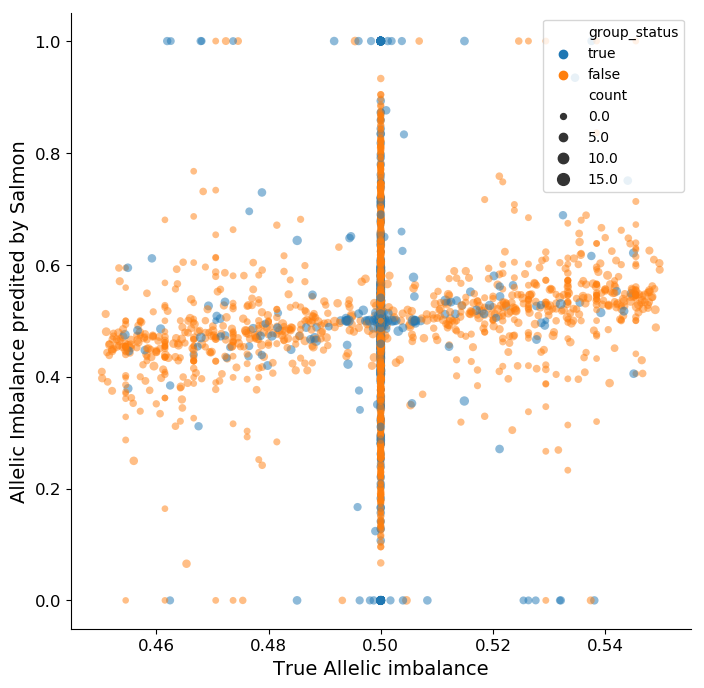

In [28]:
true_count_joined = res['joined_df'].copy()
true_count_joined['count'] = np.log(true_count_joined['count']+1)
grouped_transcripts = res['group_flat']

plt.figure(figsize=(8, 8))
ax = sns.scatterplot(
    x = 'ratio_truth',
    y = 'ratio_salmon',
    data = true_count_joined.loc[
        ((true_count_joined.ratio_truth > 0.45) & (true_count_joined.ratio_truth < 0.55))
        # & (true_count_joined['index'].isin(grouped_transcripts))
        #&~(true_count_joined['index'].isin(same_seq)) 
        #&(true_count_joined['count'] < 500)
    ],
    size = 'count',
    s = 6,
    hue = 'group_status',
    linewidth=0,
    alpha = 0.5
)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.ylabel('Allelic Imbalance predited by Salmon', fontsize = 14)
plt.xlabel('True Allelic imbalance', fontsize = 14)
#lgnd = plt.legend(frameon=False,fontsize=12)
#lgnd.legendHandles[0]._sizes = [40]
#lgnd.legendHandles[1]._sizes = [40]

sns.despine()
plt.show()